In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import operator
from enum import Enum
from typing import TypedDict

from langchain.messages import AnyMessage, ToolMessage
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel
from typing_extensions import Annotated, TypedDict

In [3]:
class Action(str, Enum):
    UPDATE = "update"
    EXTRACT = "extract"

class Subject(str, Enum):
    CLIENT = "client"
    JOB = "job"

In [4]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    command: str
    action: Action
    subject: Subject
    data_fields: list[str]

In [5]:
model = ChatOpenAI(model="gpt-4o", streaming=False)

In [6]:
# Define tools
@tool
async def update(subject: Subject, fields: list[str], values: list[str]) -> str:
    """Updates the given subject with the provided fields and values.

    subject: The subject to update.
    fields: The fields to update.
    values: The new values for the fields

    """
    return (f"UPDATE {subject} ({', '.join(f'{f}={v}' for f, v in zip(fields, values))})")


@tool
async def extract(subject: Subject) -> dict:
    """Extracts data fields from the given subject.
    subject: The subject to extract data from.

    """

    print(f"EXTRACT data fields from {subject}")
    return {}


# Augment the LLM with tools
tools = [update, extract]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [7]:
# Define the function that calls the model
system_prompt = (
    f"You are a helpful assistant that understands human commands and translates them into actions.\n"
    "You are given a command and you need to determine the appropriate action to take (update or extract) along with any necessary data fields.\n"
    "You need to identify the subject (client or job) and the relevant data fields from the command.\n"
)

human_prompt = "Command: {command}"

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", human_prompt),
    ]
)


async def call_model(state: State):
    command = state["command"]
    chain = prompt | model_with_tools
    response = await chain.ainvoke({"command": command})

    tool = response.tool_calls[0]
    subject = Subject(tool["args"]["subject"].lower())
    action = Action(tool["name"].lower())

    print(response)

    # We return a list, because this will get added to the existing list
    return {"subject": subject, "action": action, "messages": [response]}


async def tool_node(state: State):
    tool_call = state["messages"][-1].tool_calls[0]
    tool = tools_by_name[tool_call["name"]]
    result = await tool.ainvoke(tool_call["args"])
    return {"messages": [ToolMessage(content=result, tool_call_id=tool_call["id"])]}

In [8]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")
workflow.add_edge("agent", "action")

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
# workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
graph = workflow.compile()

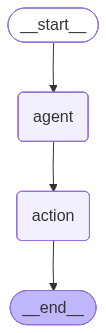

In [9]:
graph

In [10]:
import asyncio

In [11]:
result = await graph.ainvoke(
    {
        "command": "Update the customer's address to 123 Main St and phone number to 555-1234."
    }
)

content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 204, 'total_tokens': 237, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-Cb8JrvYXC5FAXOvsbQIk2D8ktzHdl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--02ceb28b-94d0-47d1-ac8c-dd04dfded34d-0' tool_calls=[{'name': 'update', 'args': {'subject': 'client', 'fields': ['address', 'phone number'], 'values': ['123 Main St', '555-1234']}, 'id': 'call_RNx9aB8KORvM70BSBk91PiNP', 'type': 'tool_call'}] usage_metadata={'input_tokens': 204, 'output_tokens': 33, 'total_tokens': 237, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio'

In [12]:
result

{'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 204, 'total_tokens': 237, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_b1442291a8', 'id': 'chatcmpl-Cb8JrvYXC5FAXOvsbQIk2D8ktzHdl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--02ceb28b-94d0-47d1-ac8c-dd04dfded34d-0', tool_calls=[{'name': 'update', 'args': {'subject': 'client', 'fields': ['address', 'phone number'], 'values': ['123 Main St', '555-1234']}, 'id': 'call_RNx9aB8KORvM70BSBk91PiNP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 204, 'output_tokens': 33, 'total_tokens': 237, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'ou